## Problem 2

In [50]:
from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

Using TensorFlow backend.


In [51]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

(60000, 784)
(10000, 784)


For each image in the train set, generate two images where the probability of a pixel value being flipped is 0.03. The  new training set size should be 120K. First, we double the train set size and then flip pixels randomly.

In [52]:
import numpy as np

In [53]:
from random import randint
x_train = np.concatenate((x_train, x_train),axis=0)
print x_train.shape

(120000, 784)


In [54]:
def pixelFlip(xtrain, percent):
    for i in range(len(xtrain)):
        toflip = [randint(0,len(xtrain[0])-1) for p in range(len(xtrain[0])*percent//100)]
        for f in toflip:
            xtrain[i][f] = 1 - xtrain[i][f]
    return xtrain

The new training set contains 120k images with noise.

In [55]:
x_train_noisy = pixelFlip(x_train, 3)

In [56]:
x_test_noisy = pixelFlip(x_test, 3)

In [57]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

We can see what a sample of the noisy test data loos like:

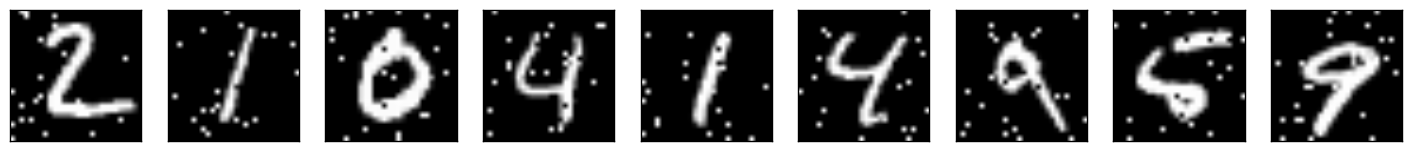

In [130]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Now we can implement a convolutional autoencoder using four different architectures. Due to computational constraints (namely access to only 4GB of RAM), I randomly sample 10% of the training data to obtain 12K images and run the CNN for 15 epochs.  I run the CNN locally to avoid crashes in the notebook.

In [60]:
from keras.datasets import mnist
from random import randint
import numpy as np
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

###### Architecture 1: using crossentropy loss function

In [ ]:
def cnn1():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

The first architecture above uses crossentropy as its loss function and results in the below MSE as a function of sample size.

In [8]:
mse1 = [0.0711,0.0225,0.0165,0.0133,0.0112,0.0099,0.0090,\
        0.0083,0.0077,0.0073,0.0069,0.0065,0.0062,0.0061,0.0058]
sampleSize = [12*i for i in range(1,16)]

Using this CNN, we note the 9 best (top) and worst (bottom) images as measured by error.

<img src="files/bw41.png">

###### Architecture 2: using MSE as loss function

The second architecture's only difference is that it uses mean squared error as its loss function. The results are shown below.

In [21]:
def cnn2():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error', metrics=['mse'])

In [12]:
mse2 = [0.0747,0.0255,0.0185,0.0154,0.0133,0.0117,\
        0.0106,0.0096,0.0090,0.0084,0.0082,0.0077,0.0073,0.0072,0.0069]

Below are the 9 best (top) and worst (bottom) integers from the test set as measured by error.

<img src="files/bw42.png">

###### Architecture 3: using hinge loss

A third architecture implements a hinge loss as the loss function.

In [22]:
def cnn3():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='hinge', metrics=['mse'])

In [14]:
mse3 = [0.6249,0.7525,0.7718,0.7819,0.7876,0.7916,0.7946,\
        0.7970,0.7989,0.8005,0.8020,0.8032,0.8043,0.8054,0.8063]

Below are the 9 best (top) and worst (bottom) integers from the test set as measured by MSE.

<img src="files/bw43.png">

###### Architecture 4: layer reduction

A fourth architectural variation reduces the number of layers to implement the following cnn.

In [62]:
def cnn4():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])
    return autoencoder

In [83]:
mse4 = [0.0711,0.0062,0.0047,0.0039,0.0034,0.0031,0.0028,\
        0.0026,0.0024,0.0023,0.0021,0.0021,0.0020,0.0019,0.0019]

Below are the 9 best (top) and worst (bottom) integers from the test set.

<img src="files/bw44.png">

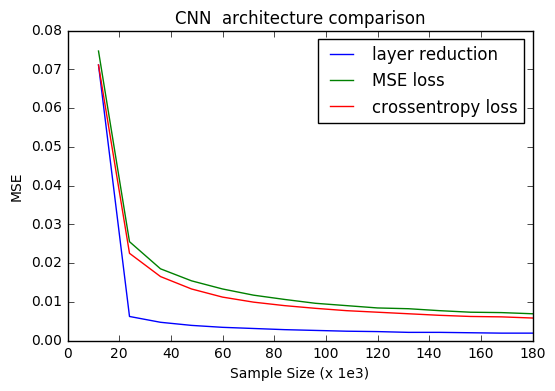

In [44]:
plt.plot(sampleSize, mse4, label='layer reduction')
plt.plot(sampleSize, mse2, label = 'MSE loss')
plt.plot(sampleSize, mse1, label='crossentropy loss')
plt.title('CNN  architecture comparison')
plt.xlabel('Sample Size (x 1e3)')
plt.ylabel('MSE')
plt.legend()
plt.show()

Interestingly, using hinge loss as the loss function yielded increaseing mean squared errors as sample size increased.

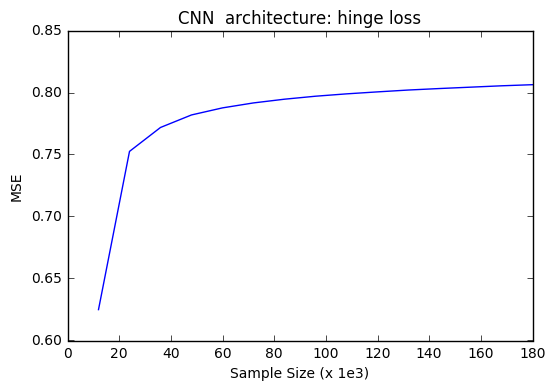

In [47]:
plt.plot(sampleSize, mse3, label='hinge loss')
plt.title('CNN  architecture: hinge loss')
plt.xlabel('Sample Size (x 1e3)')
plt.ylabel('MSE')
plt.show()

Looking at the error of all four architectures, the model with fewest layers achieves the lowest MSE, reaching 0.0019 with 180,000 samples.

To get the 10 best and worst images, we use the autoencoder to predict values based on the noisy test set. Then we can calculate the MSE compared to the clean test set and get the images with the best and worst MSE.

In [66]:
x_pred = autoencoder.predict(x_test_noisy)

The below code is run locally to avoid notebook crashes. When run, it produces the 10 best images and 10 worst images as sorted by MSE. Then the plots of the respective 20 digits is created as shown in the above examples.

In [ ]:
def mse(xpred,xtrue):
    mse = []
    for i in range(len(xpred)):
        mse.append(sum(sum(sum((xpred[i]-xtrue[i])**2))/(28*28)))
    return mse

mse = mse(x_pred, x_test)

best10 = np.argsort(mse)[:10]
worst10 = np.argsort(mse)[-10:]

best = [x_test_noisy[i] for i in best10]
worst = [x_test_noisy[j] for j in worst10]

n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(best[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(worst[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()